In [1]:
import pandas as pd

rides = pd.read_parquet('../data/transformed/validated_rides_2022_01.parquet')
rides.head()

,pickup_datetime,pickup_location_id
index,,
0,2022-01-01 00:35:40,142
1,2022-01-01 00:33:43,236
2,2022-01-01 00:53:21,166
3,2022-01-01 00:25:21,114
4,2022-01-01 00:36:48,68


In [2]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2463879 entries, 0 to 2463930
Data columns (total 2 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_datetime     datetime64[ns]
 1   pickup_location_id  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 56.4 MB


In [4]:
def transform_raw_data_into_ts_data(
    rides: pd.DataFrame
) -> pd.DataFrame:
    
    rides['pickup_hour'] = rides.pickup_datetime.dt.floor('H')
    agg_rides = rides.groupby(['pickup_hour','pickup_location_id']).count().reset_index()
    agg_rides = agg_rides.rename(columns={'pickup_datetime':'rides'})

    agg_rides_all_slots = add_missing_slots(agg_rides)
    
    return agg_rides_all_slots

In [5]:
transform_raw_data_into_ts_data(rides)

100%|██████████| 257/257 [00:00<00:00, 333.33it/s]


,pickup_hour,rides,pickup_location_id
0,2022-01-01 00:00:00,11,4
1,2022-01-01 01:00:00,15,4
2,2022-01-01 02:00:00,26,4
3,2022-01-01 03:00:00,8,4
4,2022-01-01 04:00:00,9,4
...,...,...,...
191203,2022-01-31 19:00:00,0,176
191204,2022-01-31 20:00:00,0,176
191205,2022-01-31 21:00:00,0,176
191206,2022-01-31 22:00:00,0,176


In [11]:
# rides['pickup_hour'] = rides.pickup_datetime.dt.round('H')
rides['pickup_hour'] = rides.pickup_datetime.dt.floor('H')
rides.head()

,pickup_datetime,pickup_location_id,pickup_hour
index,,,
0,2022-01-01 00:35:40,142,2022-01-01
1,2022-01-01 00:33:43,236,2022-01-01
2,2022-01-01 00:53:21,166,2022-01-01
3,2022-01-01 00:25:21,114,2022-01-01
4,2022-01-01 00:36:48,68,2022-01-01


In [110]:
agg_rides = rides.groupby(['pickup_hour','pickup_location_id']).count().reset_index()
agg_rides = agg_rides.rename(columns={'pickup_datetime':'rides'})
agg_rides

,pickup_hour,pickup_location_id,rides
0,2022-01-01 00:00:00,4,11
1,2022-01-01 00:00:00,7,6
2,2022-01-01 00:00:00,10,1
3,2022-01-01 00:00:00,12,2
4,2022-01-01 00:00:00,13,12
...,...,...,...
66863,2022-01-31 23:00:00,261,4
66864,2022-01-31 23:00:00,262,8
66865,2022-01-31 23:00:00,263,26
66866,2022-01-31 23:00:00,264,24


In [3]:
from tqdm import tqdm

def add_missing_slots(agg_rides: pd.DataFrame) -> pd.DataFrame:
    
    location_ids = agg_rides['pickup_location_id'].unique()
    full_range = pd.date_range(
        agg_rides['pickup_hour'].min(), agg_rides['pickup_hour'].max(), freq='H')
    output = pd.DataFrame()
    
    for location_id in tqdm(location_ids):

        # keep only rides for this 'location_id'
        agg_rides_i = agg_rides.loc[agg_rides.pickup_location_id == location_id, ['pickup_hour', 'rides']]
            
        # quick way to add missing dates with 0 in a Series
        # taken from https://stackoverflow.com/a/19324591
        agg_rides_i.set_index('pickup_hour', inplace=True)
        agg_rides_i.index = pd.DatetimeIndex(agg_rides_i.index)
        agg_rides_i = agg_rides_i.reindex(full_range, fill_value=0)
        
        # add back `location_id` columns
        agg_rides_i['pickup_location_id'] = location_id

        output = pd.concat([output, agg_rides_i])
    
    # move the purchase_day from the index to a dataframe column
    output = output.reset_index().rename(columns={'index': 'pickup_hour'})
    
    return output

In [112]:
agg_rides_all_slots = add_missing_slots(agg_rides)

100%|██████████| 257/257 [00:01<00:00, 141.75it/s]


In [137]:
from typing import Optional, List
import plotly.express as px

def plot_rides(
    rides: pd.DataFrame,
    locations: Optional[List[int]] = None
    ):
    """
    Plot time-series data
    """
    rides_to_plot = rides[rides.pickup_location_id.isin(locations)] if locations else rides

    fig = px.line(
        rides_to_plot,
        x="pickup_hour",
        y="rides",
        color='pickup_location_id',
        template='none',
    )

    fig.show()

In [139]:
# plot_rides(agg_rides_all_slots, locations=[43])

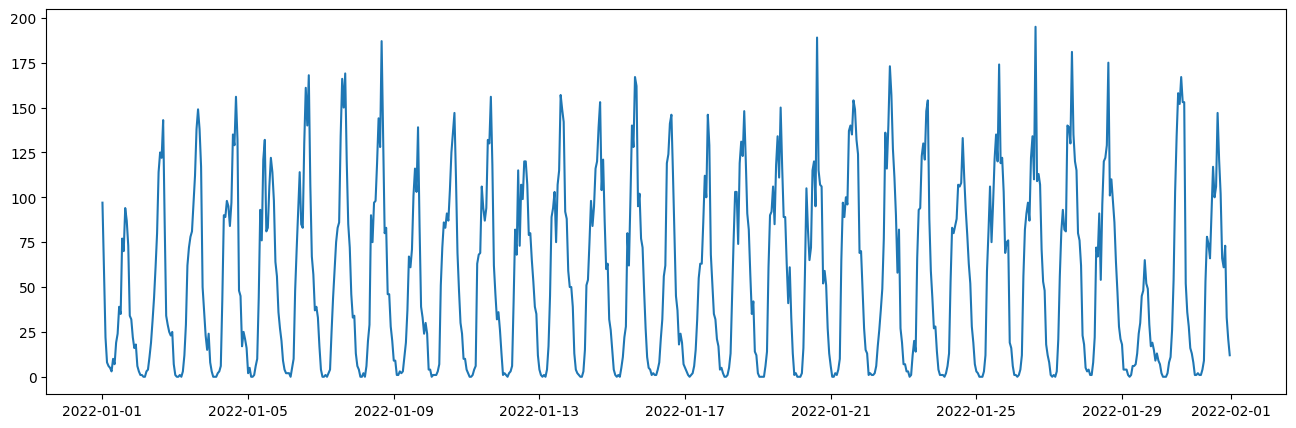

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))

plt.plot(agg_rides_all_slots[agg_rides_all_slots['pickup_location_id']==43][['pickup_hour']],
         agg_rides_all_slots[agg_rides_all_slots['pickup_location_id']==43][['rides']])


In [133]:
agg_rides_all_slots.to_parquet('../data/transformed/ts_data_2022_01.parquet')